# Feature Detection

In [3]:
# import methods from FIA python script
from FIA import *
import os

# Logging
oms.LogConfigHandler().setLogLevel("ERROR")

## Library Preparation

In [4]:
# set path to your mzML files and workfolder
data_dir = "../data/example data/exampleA_ecolistrains"
run_dir = "../runs/exampleA"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [5]:
# centroid_dir = centroid_batch(data_dir, run_dir, file_ending=".mzXML")

In [6]:
# merge_dir = merge_batch(centroid_dir, run_dir, file_ending=".mzML")           # Replaced by retention time alignment

## Common steps

In [7]:
centroid_dir = "../runs/exampleA/centroids"
"""
feature_maps = untargeted_features_detection(centroid_dir, run_dir, ".mzML", 
                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,
                                            charge_lower_bound=1, charge_upper_bound=3, 
                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",
                                            mz_scoring_by_elements="false", report_convex_hulls="true")
"""

'\nfeature_maps = untargeted_features_detection(centroid_dir, run_dir, ".mzML", \n                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,\n                                            charge_lower_bound=1, charge_upper_bound=3, \n                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",\n                                            mz_scoring_by_elements="false", report_convex_hulls="true")\n'

In [8]:
feature_maps = read_feature_maps_XML("../runs/exampleA/features/")

Reading in feature maps:


100%|██████████| 6/6 [00:30<00:00,  5.15s/it]


In [9]:
feature_maps_pol = assign_feature_maps_polarity(feature_maps)

Assign polarity to feature maps:


100%|██████████| 6/6 [00:00<00:00, 15.32it/s]


In [10]:
feature_maps_pos, feature_maps_neg = separate_feature_maps_pos_neg(feature_maps=feature_maps_pol)

Separating feature maps:


100%|██████████| 6/6 [00:00<00:00, 29365.02it/s]


## Unlabeled

adducts to expect: 
- elements, charge and probability separated by colon
the total probability of all charged adducts needs to be 1
- e.g. positive mode:
    - proton dduct "H:+:0.6", sodium adduct "Na:+:0.4" and neutral water loss "H-2O-1:0:0.2"
- e.g. negative mode:
    - with neutral formic acid adduct: "H-1:-:1", "CH2O2:0:0.5"
- multiples don't need to be specified separately:
    - e.g. [M+H2]2+ and double water loss will be detected as well!
- optionally, retention time shifts caused by adducts can be added
    - e.g. a formic acid adduct causes 3 seconds earlier elution "CH2O2:0:0.5:-3"


In [11]:
pos_adducts = [b"H:+:0.6", b"Na:+:0.1", b"K:+:0.1", b"NH4:+:0.1", b"H-1O-1:+:0.05", b"H-3O-2:+:0.05"]
feature_maps_pos_adducts = detect_adducts(feature_maps_pos, potential_adducts=pos_adducts, verbose_level=3)

neg_adducts = [b"H-1:-:0.6", b"H-3O-1:-:0.2", b"Cl:-:0.1", b"Na-1:-:0.05", b"K-1:-:0.025", b"Br:-:0.025"]
feature_maps_neg_adducts = detect_adducts(feature_maps_neg, potential_adducts=neg_adducts, verbose_level=3)

Detecting adducts:


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
store_feature_maps(feature_maps_pos_adducts, "../runs/exampleA/adduct_features", ".mzML")
store_feature_maps(feature_maps_neg_adducts, "../runs/exampleA/adduct_features", ".mzML")

In [ ]:
feature_maps_pos_algn = align_retention_times(feature_maps_pos_adducts, 
                                                max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                                max_mz_difference=10.0,
                                                mz_unit="ppm")
store_feature_maps(feature_maps_pos_algn, "../runs/exampleA/final_features", ".mzML")

feature_maps_neg_algn = align_retention_times(feature_maps_neg_adducts, 
                                                max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                                max_mz_difference=10.0,
                                                mz_unit="ppm")
store_feature_maps(feature_maps_neg_algn, "../runs/exampleA/final_features", ".mzML")

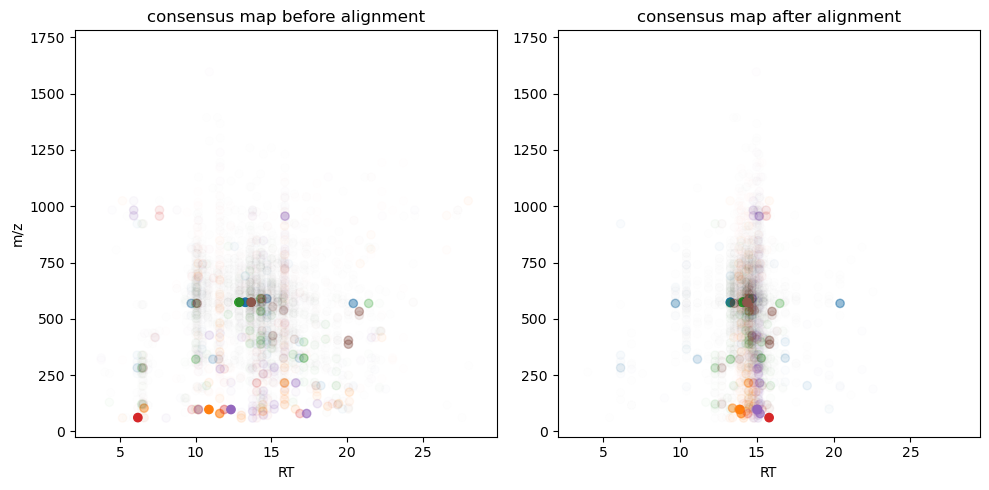

In [ ]:
plot_feature_map_rt_alignment(feature_maps_pos_algn)
plot_feature_map_rt_alignment(feature_maps_neg_algn)

## Consensus building

In [ ]:
consensus_map_pos = consensus_features_linking(feature_maps_pos_adducts, feature_grouper="KD")
consensus_map_pos = assign_feature_maps_polarity([consensus_map_pos], "positive")[0]
consensus_map_neg = consensus_features_linking(feature_maps_neg_adducts, feature_grouper="KD")
consensus_map_neg = assign_feature_maps_polarity([consensus_map_neg], "negative")[0]

Progress of 'computing RT transformations':
-- done [took 0.31 s (CPU), 0.31 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.43 s (CPU), 0.43 s (Wall)] -- 
Progress of 'computing RT transformations':
-- done [took 0.02 s (CPU), 0.02 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.05 s (CPU), 0.05 s (Wall)] -- 


In [ ]:
cm_pos_df = consensus_map_to_df(consensus_map_pos)
filtered_cm_pos_df = filter_consensus_map_df(cm_pos_df, max_missing_values=1, min_feature_quality=sorted(cm_pos_df["quality"], reverse=True)[1000])
imputed_cm_pos_df = impute_consensus_map_df(filtered_cm_pos_df, n_nearest_neighbours=2)

cm_neg_df = consensus_map_to_df(consensus_map_neg)
filtered_cm_neg_df = filter_consensus_map_df(cm_neg_df, max_missing_values=1, min_feature_quality=sorted(cm_neg_df["quality"], reverse=True)[1000])
imputed_cm_neg_df = impute_consensus_map_df(filtered_cm_neg_df, n_nearest_neighbours=2)

## Labeling

In [ ]:
mass_search_pos_df = accurate_mass_search(consensus_map_pos, "../databases/HMDB/", "../runs/exampleA/tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="positive")
mass_search_neg_df = accurate_mass_search(consensus_map_neg, "../databases/HMDB/", "../runs/exampleA/tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="negative")

Read 9635 entries from mapping file!
Read 33 entries from adduct file '../databases/HMDB/PositiveAdducts.tsv'.
Read 15 entries from adduct file '../databases/HMDB/NegativeAdducts.tsv'.
Hits by adduct: #peaks explained (# matching db entries)'
  '2M+3H2O+2H;2+' : 138 (774)
  '2M+CH3CN+H;1+' : 817 (2624)
  '2M+CH3CN+Na;1+' : 732 (2299)
  '2M+H;1+' : 982 (2948)
  '2M+K;1+' : 835 (2801)
  '2M+NH4;1+' : 827 (2628)
  '2M+Na;1+' : 941 (3216)
  'M+2CH3CN+2H;2+' : 30 (122)
  'M+2CH3CN+H;1+' : 1087 (3948)
  'M+2H+Na;3+' : 14 (81)
  'M+2H;2+' : 30 (147)
  'M+2K-H;1+' : 558 (5131)
  'M+2Na-H;1+' : 805 (4808)
  'M+2Na;2+' : 26 (58)
  'M+3CH3CN+2H;2+' : 35 (257)
  'M+3H;3+' : 8 (38)
  'M+3Na;3+' : 13 (81)
  'M+C2H6OS;1+' : 814 (4384)
  'M+C3H8O+Na+H;1+' : 953 (3926)
  'M+C3H8O;1+' : 888 (3579)
  'M+CH3CN+2H;2+' : 29 (83)
  'M+CH3CN+H;1+' : 949 (4410)
  'M+CH3CN+Na;1+' : 844 (4448)
  'M+CH3OH+H;1+' : 900 (3817)
  'M+H+2Na;3+' : 11 (133)
  'M+H+K;2+' : 27 (115)
  'M+H+NH4;2+' : 24 (78)
  'M+H+Na;2+' :

In [ ]:
id_pos_df = annotate_consensus_map_df(imputed_cm_pos_df, mass_search_pos_df, "../runs/tr1/results/result_pos.tsv")
id_neg_df = annotate_consensus_map_df(imputed_cm_neg_df, mass_search_neg_df, "../runs/tr1/results/result_neg.tsv")

In [ ]:
plot_id_df(id_pos_df)
plot_id_df(id_neg_df)

## Targeted

#### From mass, charge & retention time

In [ ]:
feature_maps = targeted_features_detection(centroid_dir, run_dir, file_ending=".mzXML", compound_library_file="../databases/compounds.tsv", 
                                           mz_window=5.0, rt_window=20.0, peak_width=60.0,
                                           mass_cutoff=[50.0, 10000.0])